In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import Dataset, DataLoader

In [2]:
NUM_CLASSES = 2
BATCH_SIZE = 64
NUM_WORKERS = 4

EPOCHS = 10
# Initial learning rate
LR = 1e-2
# Learning rate decay for LR Scheduler
GAMMA = 0.5

# Input image dimensions
H = 224
W = 224

In [51]:
TRAIN_FOLDER = '/Volumes/Project/Competition/IIT Madras/dataset/train'
TEST_FOLDER = '/Volumes/Project/Competition/IIT Madras/archive/test'

In [42]:
def get_transforms(train):
    # Since we are using pretrained ResNet-50, normalize images with ImageNet statistics
    normalization = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    if (train):
        return transforms.Compose([transforms.RandomCrop((H, W)),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   normalization,
                                   ])
    else:
        return transforms.Compose([transforms.Resize((H, W)),
                                   transforms.ToTensor(),
                                   normalization,
                                  ])

In [52]:
train_dataset = ImageFolder(root=TRAIN_FOLDER, transform=get_transforms(train=True))
test_dataset = ImageFolder(root=TEST_FOLDER, transform=get_transforms(train=False))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [30]:
def show_batch(batch_images, batch_labels, n_rows, n_cols):
    batch_size = len(batch_labels)
    assert batch_size == n_rows * n_cols
    plt.figure(figsize=(n_rows * 2, n_cols * 2))
    for i in range(batch_size):
        plt.subplot(n_cols, n_rows, i + 1)
        plt.title(batch_labels[i].item())
        plt.imshow(batch_images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

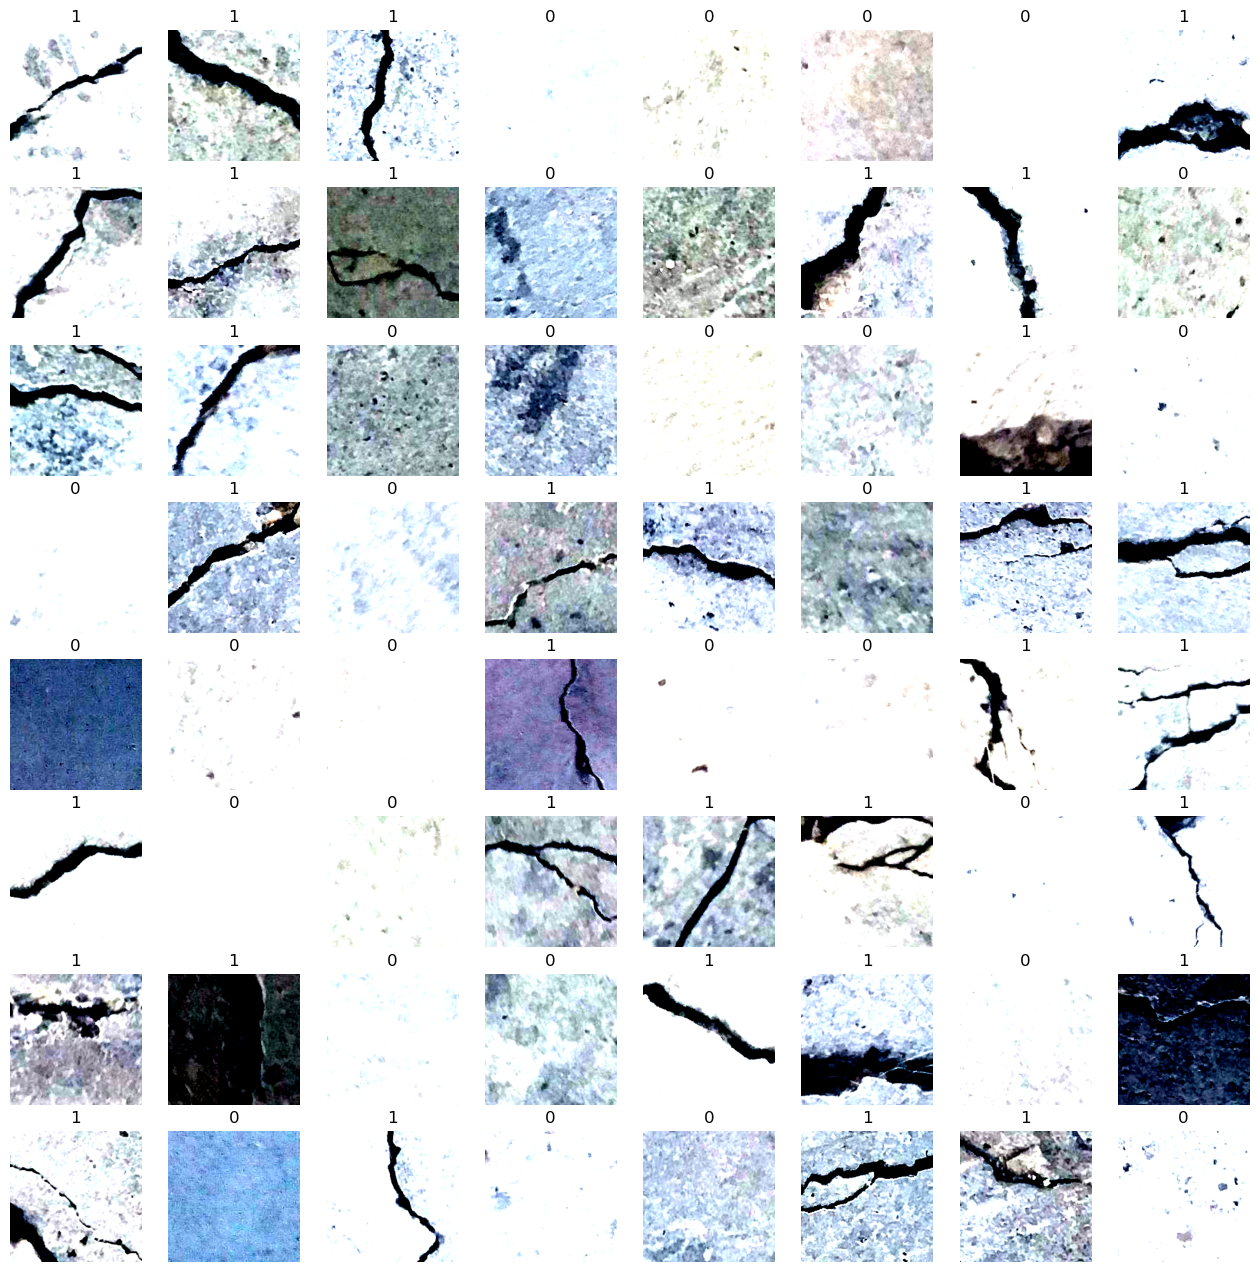

In [31]:
batch_images, batch_labels = next(iter(train_loader))
show_batch(batch_images, batch_labels, 8, 8)

In [32]:
class CrackPredictorModel(nn.Module):
    def __init__(self, n_classes=2):
        super(CrackPredictorModel, self).__init__()
        # Get pretrained ResNet50 backbone
        self.backbone = models.resnet50(weights='DEFAULT')
        
        # Freeze backbone layers
        for parameter in self.backbone.parameters():
            parameter.requires_grad = False   
        
        # Add new head
        self.backbone.fc = nn.Sequential(nn.Linear(2048, 128),
                                         nn.ReLU(),
                                         nn.Linear(128, n_classes),
                                        )

    def forward(self, x):
        return self.backbone(x)

In [33]:
device = torch.device("mps")

In [34]:
model = CrackPredictorModel(n_classes=NUM_CLASSES).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.6 * EPOCHS), int(0.8 * EPOCHS)], gamma=GAMMA)

CrackPredictorModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [35]:
def calculate_batch_metrics(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    results = predicted == y
    accuracy = results.sum() / results.shape[0]
    correct_true = (results * predicted == 1).sum()
    precision = correct_true / ((predicted == 1).sum())
    recall = correct_true / ((y == 1).sum())
    return accuracy.item(), precision.item(), recall.item()

def train(model, train_loader, criterion, optimizer, scheduler, device):
    epoch_loss = 0
    steps = 0
    epoch_accuracy = 0
    epoch_precision = 0
    epoch_recall = 0

    model.train()
    for images, labels in tqdm(train_loader):
        steps += 1
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        accuracy, precision, recall = calculate_batch_metrics(outputs, labels)
        epoch_accuracy += accuracy
        epoch_precision += precision
        epoch_recall += recall

        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
       
    scheduler.step()
    epoch_loss /= steps
    epoch_accuracy = 100.0 * epoch_accuracy / steps
    epoch_precision = 100.0 * epoch_precision / steps
    epoch_recall = 100.0 * epoch_recall / steps

    print(f"Train epoch Loss: {epoch_loss:.5f} Accuracy: {epoch_accuracy:.3f} % Precision: {epoch_precision:.3f} % Recall: {epoch_recall:.3f} %")
    return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall
    
def test(model, test_loader, criterion, device):
    test_loss = 0
    steps = 0
    test_accuracy = 0
    test_precision = 0
    test_recall = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            accuracy, precision, recall = calculate_batch_metrics(outputs, labels)
            test_accuracy += accuracy
            test_precision += precision
            test_recall += recall
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        test_loss /= steps
        test_accuracy = 100.0 * test_accuracy / steps
        test_precision = 100.0 * test_precision / steps
        test_recall = 100.0 * test_recall / steps
        print(f"Test Loss: {test_loss:.5f} Accuracy: {test_accuracy:.3f} % Precision: {test_precision:.3f} % Recall: {test_recall:.3f} %")

In [36]:
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []

for epoch in range(EPOCHS):
    loss, accuracy, precision, recall = train(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(loss)
    train_accuracies.append(accuracy)
    train_precisions.append(precision)
    train_recalls.append(recall)    

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


Train epoch Loss: 0.04708 Accuracy: 98.293 % Precision: nan % Recall: 98.293 %


100%|██████████| 625/625 [04:33<00:00,  2.28it/s]  


Train epoch Loss: 0.02232 Accuracy: 99.290 % Precision: 99.335 % Recall: 99.247 %


100%|██████████| 625/625 [05:28<00:00,  1.91it/s]


Train epoch Loss: 0.02189 Accuracy: 99.282 % Precision: 99.256 % Recall: 99.299 %


100%|██████████| 625/625 [04:06<00:00,  2.53it/s]


Train epoch Loss: 0.01723 Accuracy: 99.440 % Precision: 99.447 % Recall: 99.432 %


100%|██████████| 625/625 [04:22<00:00,  2.38it/s]


Train epoch Loss: 0.01930 Accuracy: 99.400 % Precision: 99.418 % Recall: 99.387 %


100%|██████████| 625/625 [04:04<00:00,  2.55it/s]


Train epoch Loss: 0.01751 Accuracy: 99.420 % Precision: 99.465 % Recall: 99.393 %


100%|██████████| 625/625 [04:05<00:00,  2.55it/s]


Train epoch Loss: 0.01140 Accuracy: 99.612 % Precision: 99.619 % Recall: 99.611 %


100%|██████████| 625/625 [04:04<00:00,  2.55it/s]


Train epoch Loss: 0.01156 Accuracy: 99.612 % Precision: 99.634 % Recall: 99.585 %


100%|██████████| 625/625 [04:04<00:00,  2.55it/s]


Train epoch Loss: 0.01088 Accuracy: 99.640 % Precision: 99.659 % Recall: 99.616 %


100%|██████████| 625/625 [04:05<00:00,  2.55it/s]

Train epoch Loss: 0.00956 Accuracy: 99.672 % Precision: 99.694 % Recall: 99.658 %


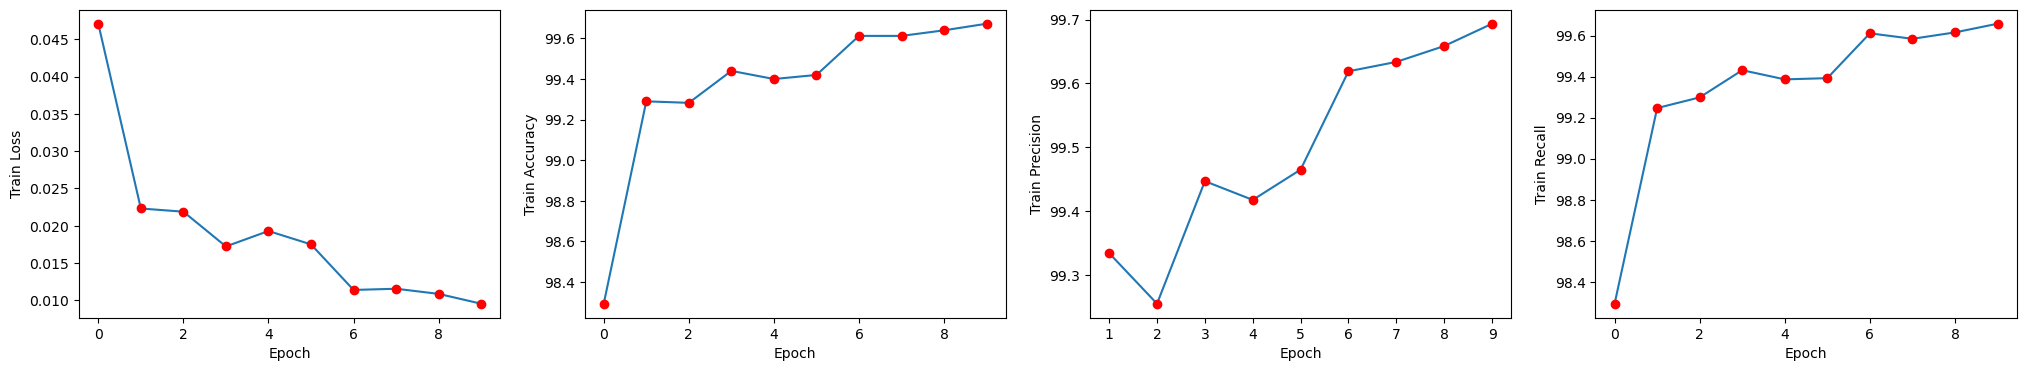

In [37]:
plt.figure(figsize=(25, 4))
plt.subplot(1, 4, 1)
plt.plot(train_losses, zorder=1)
plt.scatter([i for i in range(len(train_losses))], train_losses, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")

plt.subplot(1, 4, 2)
plt.plot(train_accuracies, zorder=1)
plt.scatter([i for i in range(len(train_accuracies))], train_accuracies, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")

plt.subplot(1, 4, 3)
plt.plot(train_precisions, zorder=1)
plt.scatter([i for i in range(len(train_precisions))], train_precisions, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Precision")

plt.subplot(1, 4, 4)
plt.plot(train_recalls, zorder=1)
plt.scatter([i for i in range(len(train_recalls))], train_recalls, c='r', zorder=2)
plt.xlabel("Epoch")
plt.ylabel("Train Recall")
plt.show()

In [53]:
test(model, test_loader, criterion, device)

100%|██████████| 4/4 [00:22<00:00,  5.72s/it]

Test Loss: 0.02554 Accuracy: 99.219 % Precision: 100.000 % Recall: 98.333 %
